# Logistic Regression and SGD Homework 
***
**Name**: $<$Xu Han$>$ 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [2]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1
def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [3]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

In [4]:
print ("the number of words in the vocabulary is", len(vocab))
print ("label 0 represents the class of automobiles while label 1 represents the class of motorcycles")

the number of words in the vocabulary is 5327
label 0 represents the class of automobiles while label 1 represents the class of motorcycles


Explaination: according to the code, these two classes first read in the content of "negative" and "positive" file line by line and then map each word a vector based on the vocabulary. This text model is the bag of words model and all the stop words are not included in the vocabulary.

### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [5]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        
        self.former_iteration = np.zeros(len(self.w))-1
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=5, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        
        # TODO implement LSR updates of weights 
        #self.w = self.w 
       
        #without regularizaiton
        #gradient = (self.sigmoid(self.w.dot(train_example.x))-train_example.y)*train_example.x
        #self.w = self.w-self.eta*gradient
        
        #LSR
        sig_minus_y = self.sigmoid(self.w.dot(train_example.x))-train_example.y
        for k in np.nonzero(train_example.x)[0]:
            #unregularized part
            gradient = sig_minus_y*train_example.x[k]
            self.w[k] = self.w[k]-self.eta*gradient
            #regularized part
            if k != 0:    #exclude bias
                self.w[k] = self.w[k]*pow((1-2*self.eta*self.lam), iteration-self.former_iteration[k])
                self.former_iteration[k] = iteration
        
                
                
        
        
        

In [6]:
lr = LogReg(train_set, test_set, lam=0.0, eta=0.1)
lr.train(isVerbose=True)

Update     0  TrnNLL  799.294  TstNLL   81.287  TrnA 0.498  TstA 0.534
Update     5  TrnNLL  679.659  TstNLL   67.393  TrnA 0.635  TstA 0.664
Update    10  TrnNLL  3699.404  TstNLL  364.627  TrnA 0.510  TstA 0.552
Update    15  TrnNLL  3376.659  TstNLL  330.103  TrnA 0.523  TstA 0.560
Update    20  TrnNLL  2480.028  TstNLL  244.475  TrnA 0.553  TstA 0.586
Update    25  TrnNLL  2445.886  TstNLL  242.589  TrnA 0.559  TstA 0.586
Update    30  TrnNLL  1404.998  TstNLL  147.011  TrnA 0.663  TstA 0.647
Update    35  TrnNLL  957.733  TstNLL  106.194  TrnA 0.734  TstA 0.724
Update    40  TrnNLL  521.316  TstNLL   69.788  TrnA 0.819  TstA 0.784
Update    45  TrnNLL  467.808  TstNLL   57.568  TrnA 0.839  TstA 0.819
Update    50  TrnNLL  459.871  TstNLL   57.341  TrnA 0.842  TstA 0.819
Update    55  TrnNLL  442.292  TstNLL   57.689  TrnA 0.847  TstA 0.793
Update    60  TrnNLL  431.716  TstNLL   54.376  TrnA 0.853  TstA 0.819
Update    65  TrnNLL  431.508  TstNLL   54.356  TrnA 0.853  TstA 0.819
U

Update   585  TrnNLL  130.762  TstNLL   23.134  TrnA 0.955  TstA 0.905
Update   590  TrnNLL  129.563  TstNLL   23.089  TrnA 0.955  TstA 0.897
Update   595  TrnNLL  132.610  TstNLL   22.659  TrnA 0.954  TstA 0.914
Update   600  TrnNLL  132.680  TstNLL   22.569  TrnA 0.954  TstA 0.922
Update   605  TrnNLL  132.057  TstNLL   22.638  TrnA 0.954  TstA 0.897
Update   610  TrnNLL  131.154  TstNLL   22.344  TrnA 0.957  TstA 0.914
Update   615  TrnNLL  131.141  TstNLL   22.342  TrnA 0.958  TstA 0.914
Update   620  TrnNLL  131.133  TstNLL   21.907  TrnA 0.958  TstA 0.914
Update   625  TrnNLL  137.285  TstNLL   21.713  TrnA 0.958  TstA 0.914
Update   630  TrnNLL  133.080  TstNLL   21.577  TrnA 0.959  TstA 0.914
Update   635  TrnNLL  133.013  TstNLL   21.576  TrnA 0.959  TstA 0.914
Update   640  TrnNLL  132.809  TstNLL   21.564  TrnA 0.959  TstA 0.914
Update   645  TrnNLL  130.864  TstNLL   21.676  TrnA 0.960  TstA 0.914
Update   650  TrnNLL  129.429  TstNLL   21.864  TrnA 0.959  TstA 0.914
Update

Update  1175  TrnNLL   55.340  TstNLL   19.258  TrnA 0.986  TstA 0.940
Update  1180  TrnNLL   55.247  TstNLL   19.175  TrnA 0.986  TstA 0.940
Update  1185  TrnNLL   55.000  TstNLL   19.233  TrnA 0.986  TstA 0.940
Update  1190  TrnNLL   54.827  TstNLL   19.168  TrnA 0.986  TstA 0.940
Update  1195  TrnNLL   54.724  TstNLL   19.006  TrnA 0.986  TstA 0.931
Update  1200  TrnNLL   54.711  TstNLL   19.000  TrnA 0.986  TstA 0.931
Update  1205  TrnNLL   55.066  TstNLL   19.805  TrnA 0.984  TstA 0.940
Update  1210  TrnNLL   55.050  TstNLL   20.023  TrnA 0.984  TstA 0.931
Update  1215  TrnNLL   55.178  TstNLL   20.086  TrnA 0.984  TstA 0.931
Update  1220  TrnNLL   55.194  TstNLL   20.094  TrnA 0.984  TstA 0.931
Update  1225  TrnNLL   55.104  TstNLL   20.058  TrnA 0.984  TstA 0.931
Update  1230  TrnNLL   55.171  TstNLL   20.100  TrnA 0.984  TstA 0.931
Update  1235  TrnNLL   55.142  TstNLL   20.063  TrnA 0.984  TstA 0.931
Update  1240  TrnNLL   55.759  TstNLL   20.522  TrnA 0.983  TstA 0.931
Update

Update  1770  TrnNLL   87.774  TstNLL   20.275  TrnA 0.984  TstA 0.931
Update  1775  TrnNLL   85.713  TstNLL   19.561  TrnA 0.984  TstA 0.931
Update  1780  TrnNLL   81.865  TstNLL   18.244  TrnA 0.989  TstA 0.931
Update  1785  TrnNLL   81.914  TstNLL   18.280  TrnA 0.989  TstA 0.931
Update  1790  TrnNLL   81.918  TstNLL   18.284  TrnA 0.989  TstA 0.931
Update  1795  TrnNLL   81.066  TstNLL   18.039  TrnA 0.989  TstA 0.931
Update  1800  TrnNLL   81.108  TstNLL   18.078  TrnA 0.989  TstA 0.931
Update  1805  TrnNLL  101.378  TstNLL   27.587  TrnA 0.982  TstA 0.931
Update  1810  TrnNLL   87.032  TstNLL   23.658  TrnA 0.987  TstA 0.931
Update  1815  TrnNLL   87.076  TstNLL   23.673  TrnA 0.987  TstA 0.931
Update  1820  TrnNLL   87.179  TstNLL   23.691  TrnA 0.987  TstA 0.931
Update  1825  TrnNLL   87.347  TstNLL   23.753  TrnA 0.986  TstA 0.931
Update  1830  TrnNLL   86.574  TstNLL   23.549  TrnA 0.987  TstA 0.931
Update  1835  TrnNLL   86.426  TstNLL   23.524  TrnA 0.987  TstA 0.931
Update

Update  2380  TrnNLL   24.507  TstNLL   14.535  TrnA 0.996  TstA 0.957
Update  2385  TrnNLL   24.420  TstNLL   14.558  TrnA 0.996  TstA 0.957
Update  2390  TrnNLL   24.424  TstNLL   14.556  TrnA 0.996  TstA 0.957
Update  2395  TrnNLL   24.485  TstNLL   14.530  TrnA 0.996  TstA 0.957
Update  2400  TrnNLL   24.408  TstNLL   14.540  TrnA 0.996  TstA 0.957
Update  2405  TrnNLL   24.231  TstNLL   14.623  TrnA 0.996  TstA 0.957
Update  2410  TrnNLL   24.234  TstNLL   14.622  TrnA 0.996  TstA 0.957
Update  2415  TrnNLL   24.251  TstNLL   14.612  TrnA 0.996  TstA 0.957
Update  2420  TrnNLL   24.162  TstNLL   14.651  TrnA 0.996  TstA 0.957
Update  2425  TrnNLL   24.285  TstNLL   14.612  TrnA 0.996  TstA 0.957
Update  2430  TrnNLL   22.926  TstNLL   14.870  TrnA 0.996  TstA 0.948
Update  2435  TrnNLL   22.872  TstNLL   14.914  TrnA 0.996  TstA 0.948
Update  2440  TrnNLL   22.869  TstNLL   14.920  TrnA 0.996  TstA 0.948
Update  2445  TrnNLL   22.828  TstNLL   14.946  TrnA 0.996  TstA 0.948
Update

Update  2965  TrnNLL   18.685  TstNLL   14.226  TrnA 0.997  TstA 0.957
Update  2970  TrnNLL   18.684  TstNLL   14.227  TrnA 0.997  TstA 0.957
Update  2975  TrnNLL   18.680  TstNLL   14.231  TrnA 0.997  TstA 0.957
Update  2980  TrnNLL   18.679  TstNLL   14.236  TrnA 0.997  TstA 0.957
Update  2985  TrnNLL   18.613  TstNLL   14.276  TrnA 0.997  TstA 0.957
Update  2990  TrnNLL   18.577  TstNLL   14.288  TrnA 0.997  TstA 0.957
Update  2995  TrnNLL   18.576  TstNLL   14.294  TrnA 0.997  TstA 0.957
Update  3000  TrnNLL   18.458  TstNLL   14.412  TrnA 0.997  TstA 0.957
Update  3005  TrnNLL   18.453  TstNLL   14.423  TrnA 0.997  TstA 0.957
Update  3010  TrnNLL   18.453  TstNLL   14.423  TrnA 0.997  TstA 0.957
Update  3015  TrnNLL   18.140  TstNLL   14.815  TrnA 0.997  TstA 0.957
Update  3020  TrnNLL   18.019  TstNLL   14.845  TrnA 0.997  TstA 0.957
Update  3025  TrnNLL   17.891  TstNLL   14.517  TrnA 0.997  TstA 0.957
Update  3030  TrnNLL   17.860  TstNLL   14.569  TrnA 0.997  TstA 0.957
Update

Update  3560  TrnNLL   13.819  TstNLL   13.682  TrnA 0.999  TstA 0.957
Update  3565  TrnNLL   13.834  TstNLL   13.629  TrnA 0.999  TstA 0.957
Update  3570  TrnNLL   13.794  TstNLL   13.670  TrnA 0.999  TstA 0.957
Update  3575  TrnNLL   13.787  TstNLL   13.690  TrnA 0.999  TstA 0.957
Update  3580  TrnNLL   13.759  TstNLL   13.810  TrnA 0.999  TstA 0.957
Update  3585  TrnNLL   13.751  TstNLL   13.787  TrnA 0.999  TstA 0.957
Update  3590  TrnNLL   13.727  TstNLL   13.831  TrnA 0.999  TstA 0.957
Update  3595  TrnNLL   13.777  TstNLL   13.764  TrnA 0.999  TstA 0.957
Update  3600  TrnNLL   13.763  TstNLL   13.778  TrnA 0.999  TstA 0.957
Update  3605  TrnNLL   13.743  TstNLL   13.822  TrnA 0.999  TstA 0.957
Update  3610  TrnNLL   13.730  TstNLL   13.760  TrnA 0.999  TstA 0.957
Update  3615  TrnNLL   13.729  TstNLL   13.601  TrnA 0.999  TstA 0.957
Update  3620  TrnNLL   13.735  TstNLL   13.575  TrnA 0.999  TstA 0.957
Update  3625  TrnNLL   13.666  TstNLL   13.674  TrnA 0.999  TstA 0.957
Update

Update  4155  TrnNLL   12.181  TstNLL   14.032  TrnA 0.999  TstA 0.957
Update  4160  TrnNLL   12.181  TstNLL   14.032  TrnA 0.999  TstA 0.957
Update  4165  TrnNLL   11.930  TstNLL   13.822  TrnA 0.999  TstA 0.957
Update  4170  TrnNLL   11.930  TstNLL   13.822  TrnA 0.999  TstA 0.957
Update  4175  TrnNLL   11.930  TstNLL   13.822  TrnA 0.999  TstA 0.957
Update  4180  TrnNLL   11.905  TstNLL   13.883  TrnA 0.999  TstA 0.957
Update  4185  TrnNLL   11.905  TstNLL   13.883  TrnA 0.999  TstA 0.957
Update  4190  TrnNLL   11.902  TstNLL   13.831  TrnA 0.999  TstA 0.957
Update  4195  TrnNLL   11.866  TstNLL   13.806  TrnA 0.999  TstA 0.957
Update  4200  TrnNLL   11.865  TstNLL   13.792  TrnA 0.999  TstA 0.957
Update  4205  TrnNLL   11.865  TstNLL   13.779  TrnA 0.999  TstA 0.957
Update  4210  TrnNLL   11.865  TstNLL   13.775  TrnA 0.999  TstA 0.957
Update  4215  TrnNLL   11.866  TstNLL   13.777  TrnA 0.999  TstA 0.957
Update  4220  TrnNLL   11.865  TstNLL   13.780  TrnA 0.999  TstA 0.957
Update

Update  4755  TrnNLL   10.938  TstNLL   13.679  TrnA 0.999  TstA 0.957
Update  4760  TrnNLL   10.936  TstNLL   13.686  TrnA 0.999  TstA 0.957
Update  4765  TrnNLL   10.935  TstNLL   13.686  TrnA 0.999  TstA 0.957
Update  4770  TrnNLL   10.917  TstNLL   13.692  TrnA 0.999  TstA 0.957
Update  4775  TrnNLL   10.925  TstNLL   13.612  TrnA 0.999  TstA 0.957
Update  4780  TrnNLL   10.889  TstNLL   13.671  TrnA 0.999  TstA 0.957
Update  4785  TrnNLL   10.887  TstNLL   13.672  TrnA 0.999  TstA 0.957
Update  4790  TrnNLL   10.877  TstNLL   13.692  TrnA 0.999  TstA 0.957
Update  4795  TrnNLL   10.877  TstNLL   13.691  TrnA 0.999  TstA 0.957
Update  4800  TrnNLL   10.895  TstNLL   13.621  TrnA 0.999  TstA 0.957
Update  4805  TrnNLL   10.870  TstNLL   13.689  TrnA 0.999  TstA 0.957
Update  4810  TrnNLL   10.869  TstNLL   13.680  TrnA 0.999  TstA 0.957
Update  4815  TrnNLL   10.874  TstNLL   13.663  TrnA 0.999  TstA 0.957
Update  4820  TrnNLL   10.868  TstNLL   13.645  TrnA 0.999  TstA 0.957
Update

Update  5340  TrnNLL   10.102  TstNLL   14.050  TrnA 0.999  TstA 0.957
Update  5345  TrnNLL   10.093  TstNLL   14.016  TrnA 0.999  TstA 0.957
Update  5350  TrnNLL   10.064  TstNLL   14.000  TrnA 0.999  TstA 0.957
Update  5355  TrnNLL   10.061  TstNLL   14.033  TrnA 0.999  TstA 0.957
Update  5360  TrnNLL   10.059  TstNLL   14.078  TrnA 0.999  TstA 0.957
Update  5365  TrnNLL   10.059  TstNLL   14.075  TrnA 0.999  TstA 0.957
Update  5370  TrnNLL   10.055  TstNLL   14.121  TrnA 0.999  TstA 0.957
Update  5375  TrnNLL   10.055  TstNLL   14.121  TrnA 0.999  TstA 0.957


The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [7]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [8]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

In [9]:
lam_test = [0.0,0.00000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1.0,5.0]
run_times = [0,1,2,3,4,5,6,7,8,9]
predict_accuracy = []
accuracy = np.zeros((10,18)) 
for j in run_times:
    count = 0
    for ii in lam_test:
        lr = LogReg(train_set, test_set, lam=ii, eta=0.1)
        lr.train(isVerbose=False)
        accuracy[j][count] = lr.test_acc[-1]
        count += 1
        

for ii in range(0,count):
    sum =0
    for j in run_times:
        sum +=accuracy[j][ii]
    predict_accuracy.append(sum/10)
    print('When the regularization parameter is ', lam_test[ii] , 'the average accuracy of the test set after 10 rounds is ', sum/10)
        

When the regularization parameter is  0.0 the average accuracy of the test set after 10 rounds is  0.958620689655
When the regularization parameter is  1e-08 the average accuracy of the test set after 10 rounds is  0.956896551724
When the regularization parameter is  1e-06 the average accuracy of the test set after 10 rounds is  0.958620689655
When the regularization parameter is  1e-05 the average accuracy of the test set after 10 rounds is  0.960344827586
When the regularization parameter is  0.0001 the average accuracy of the test set after 10 rounds is  0.958620689655
When the regularization parameter is  0.001 the average accuracy of the test set after 10 rounds is  0.95775862069
When the regularization parameter is  0.01 the average accuracy of the test set after 10 rounds is  0.937931034483
When the regularization parameter is  0.1 the average accuracy of the test set after 10 rounds is  0.846551724138
When the regularization parameter is  1.0 the average accuracy of the test se

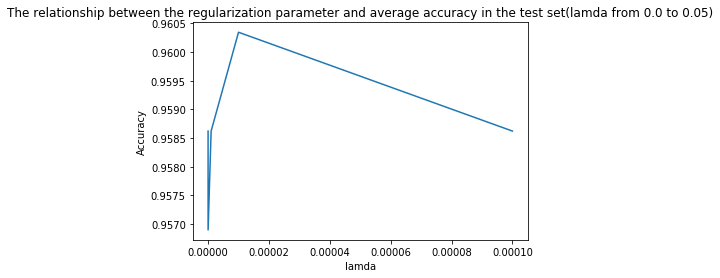

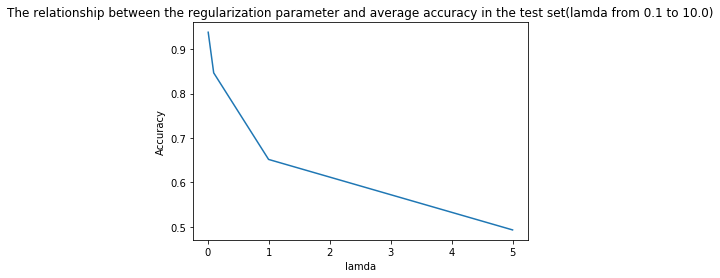

In [11]:
#draw graph
plt.title('The relationship between the regularization parameter and average accuracy in the test set(lamda from 0.0 to 0.05)')
plt.plot(lam_test[:5], predict_accuracy[:5])
plt.xlabel('lamda')
plt.ylabel('Accuracy')
plt.show()

plt.title('The relationship between the regularization parameter and average accuracy in the test set(lamda from 0.1 to 10.0)')
plt.plot(lam_test[6:10], predict_accuracy[6:10])
plt.xlabel('lamda')
plt.ylabel('Accuracy')
plt.show()

In order to make the results more convicing and eliminate the random error, I trained the model for ten times with 5 epoches in each lamda and calculate the average accuracy. The whole process was under the situation where eta = 0.1
From the graph we can see that when lamda is extremely small, the acuracy has better performance. When the lamda becomes largger, the relationship basically follows the pattern that the higher of the lamda is, the lower the accuracy is. In this particular case, when lamda equals to 0.00001, the model has the best performance.

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

In [12]:
eta_test = [0.01,0.05,0.1,0.5,1.0,2.0,10.0]
count = 0
nll_value = {}
for jj in eta_test:
    lr = LogReg(train_set, test_set, lam=0.00001, eta=jj)
    lr.train(isVerbose=False)
    nll_value[count] = lr.test_nll
    count += 1

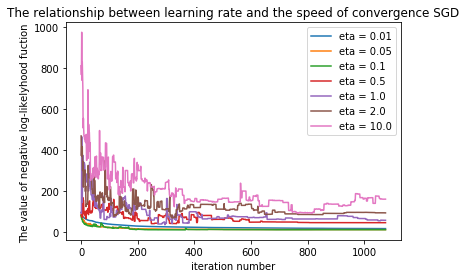

In [13]:
#draw graph
plt.title('The relationship between learning rate and the speed of convergence SGD')
count = 0
for jj in eta_test:
    plt.plot(nll_value[count])
    count += 1
plt.xlabel('iteration number')
plt.ylabel('The value of negative log-likelyhood fuction ')
plt.legend(labels=['eta = 0.01','eta = 0.05', 'eta = 0.1','eta = 0.5','eta = 1.0','eta = 2.0','eta = 10.0'],loc="best")
plt.show()

The training process was under lam = 0.00001 with 5 epoches. The graph indicates the relationship between learning rate and the speed of convergence. According to the convergence trend, when learning rate equals to 0.05, the model has the fastest convergence speed.
We could also draw some other conclusions here: when the learning rate is too samll, like eta = 0.01, the speed slows down; when the learning rate is too large, like eta = 0.1,0.5,1.0,2.0,10.0, the trend of convergence becomes very unstable and cannot converge in a short time.

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [22]:
run_times = [0,1,2,3,4,5,6,7,8,9]
w_average = np.zeros(len(vocab))
w_sum = np.zeros(len(vocab))
for j in run_times:
    lr = LogReg(train_set, test_set, lam=0.00001, eta=0.05)
    lr.train(isVerbose=False)
    w_sum += lr.w
w_average = w_sum/10
        
w_sorted = np.sort(w_average)
for i in range(0,10):
    print("Top ", i+1, "best predictors for negative class is: ", vocab[w_average.tolist().index(w_sorted[i+1])], " the weight is: ",w_sorted[i+1])
for i in range(0,10):
    print("Top ", i+1, "best predictors for popsitive class is: ", vocab[w_average.tolist().index(w_sorted[-(i+1)])], " the weight is: ",w_sorted[-(i+1)])
    

Top  1 best predictors for negative class is:  cars  the weight is:  -1.16071948489
Top  2 best predictors for negative class is:  requests  the weight is:  -0.610957825085
Top  3 best predictors for negative class is:  toyota  the weight is:  -0.556805318501
Top  4 best predictors for negative class is:  warning  the weight is:  -0.549583606661
Top  5 best predictors for negative class is:  ford  the weight is:  -0.53416933993
Top  6 best predictors for negative class is:  send  the weight is:  -0.477266826498
Top  7 best predictors for negative class is:  eliot  the weight is:  -0.466942599758
Top  8 best predictors for negative class is:  truck  the weight is:  -0.436120985646
Top  9 best predictors for negative class is:  saturn  the weight is:  -0.43362524473
Top  10 best predictors for negative class is:  acs  the weight is:  -0.425694402767
Top  1 best predictors for popsitive class is:  bike  the weight is:  2.03591559861
Top  2 best predictors for popsitive class is:  dod  the

In order to eliminate the random error, I trained the model for ten times with 5 epoches. The whole process was under the situation where eta = 0.05 and lam = 0.00001. In mathematical aspect, the higher the absoluate value of a weight, the more contribution the corresponding word will make. In this case, if we can find the top 10 weights who have mixmum value and their corresponding words, the best predictors for positive class will be identified. The same thing happens to negative class, top 10 words who have minimum value will be the best predictors for negative class. In my code, I first sort the weight vector, then find the top 10 maximum and minimum weights and then find the corresponding words, which will be the best predictors.  

**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [23]:
w_negative = []
w_positive = []
for j in range(len(w_average)):
    if w_average[j] <0:
        w_negative.append(w_average[j])
    else:
        w_positive.append(w_average[j])
print("There are ", len(w_negative)," negative prodictors and ", len(w_positive)," positive predictors")

w_negative_sorted = np.sort(np.array(w_negative))
w_positive_sorted = np.sort(np.array(w_positive))
#print(w_negative_sorted)
#print(w_positive_sorted)


for i in range(0,10):
    count = 0
    j =0
    if(i<j+count):
        continue
    else:
        j=i
        if(w_negative_sorted[-(i+1)] == w_negative_sorted[-i]):
            for idx in range(len(w_average)): # there are words who have the same weights
                if w_average[idx] == w_negative_sorted[-(i+1)] :
                    count +=1
                    if(count >10):
                        continue
                    else:
                        print("Top ", i+1, "worst predictors for negative class is: ", vocab[idx], " the weight is: ",w_negative_sorted[-(i+1)])   
                    
        else:
            print("Top ", i+1, "worst predictors for negative class is: ", vocab[w_average.tolist().index(w_negative_sorted[-(i+1)])], " the weight is: ",w_negative_sorted[-(i+1)])


for i in range(0,10):
    count = 0
    j =0
    if(i<j+count):
        continue
    else:
        j=i
        if(w_positive_sorted[i+1] == w_positive_sorted[i]):
            for idx in range(len(w_average)): # there are words who have the same weights
                if w_average[idx] == w_positive_sorted[i] :
                    count +=1
                    if(count >10):
                        continue
                    else:
                        print("Top ", i+1, "worst predictors for positive class is: ", vocab[idx], " the weight is: ",w_positive_sorted[-1])   
                   
                
        else:
            print("Top ", i+1, "worst predictors for positive class is: ", vocab[w_average.tolist().index(w_positive_sorted[i])], " the weight is: ",w_positive_sorted[i])

There are  2655  negative prodictors and  2672  positive predictors
Top  1 worst predictors for negative class is:  sounding  the weight is:  -5.93501340094e-10
Top  2 worst predictors for negative class is:  obey  the weight is:  -1.8340229664e-09
Top  3 worst predictors for negative class is:  towing  the weight is:  -1.45963380724e-07
Top  4 worst predictors for negative class is:  goodyear  the weight is:  -5.94971619502e-07
Top  5 worst predictors for negative class is:  match  the weight is:  -5.67864672383e-05
Top  6 worst predictors for negative class is:  orleans  the weight is:  -6.05232956668e-05
Top  7 worst predictors for negative class is:  criteria  the weight is:  -8.59445450149e-05
Top  8 worst predictors for negative class is:  health  the weight is:  -9.0453240017e-05
Top  9 worst predictors for negative class is:  extensive  the weight is:  -9.69422091717e-05
Top  10 worst predictors for negative class is:  buyers  the weight is:  -0.00010690028855
Top  1 worst pred

In order to eliminate the random error, I trained the model for ten times with 5 epoches. The whole process was under the situation where eta = 0.05 and lam = 0.00001.
As I have explained before, in mathematical aspect, the lower the absoluate value of a weight, the less contribution the corresponding word will make. In this case, if we can find the top 10 weights who have minimum absolute value in both negative and positive classes, as well as their corresponding words, the worst predictors will be identified. 
In my code, I first find out all the weights in positive and negative classes, then find the top 10 weights with minimum absolute value in both classes and then find the corresponding words, which will be the worst predictors.

